In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load sph_dynamic.csv into a Pandas dataframe and display the first 5 rows of the data
dynamic_data = pd.read_csv('data/sph_dynamic.csv')
dynamic_data.head()

,stay_id,charttime,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,...,ph,lactate,pt,urineoutput,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal
0,35715575,2148-12-27 18:15:00.000,NaN,8.5,0.9,137.0,138.0,104.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34483718,2118-01-04 03:58:00.000,NaN,8.2,0.8,129.0,141.0,101.0,NaN,NaN,...,NaN,NaN,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31826892,2163-03-10 19:59:00.000,NaN,7.7,0.4,112.0,136.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36154799,2131-12-02 19:14:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32732521,2116-08-12 12:45:00.000,NaN,NaN,4.0,135.0,139.0,105.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Get the number of missing values in each column of the dynamic_data
dynamic_data.isnull().sum()

stay_id                   0
charttime                 0
total_protein          6930
calcium                 933
creatinine              261
glucose                 444
sodium                  214
chloride                241
heart_rate             6833
sbp                    6895
dbp                    6895
mbp                    6887
resp_rate              6832
temperature            6974
hemoglobin             1179
wbc                    1207
alt                    3964
ast                    3936
alp                    3976
bilirubin_total        3957
bilirubin_direct       6808
bilirubin_indirect     6812
ph                     7004
lactate                7012
pt                     3068
urineoutput            6942
sofa_respiration       7005
sofa_coagulation       7023
sofa_liver             7023
sofa_cardiovascular    6872
sofa_cns               6979
sofa_renal             7024
dtype: int64

In [4]:
# Drop the columns in dynamic_data with more than 80% of the values
for col in dynamic_data.columns:
    if dynamic_data[col].isnull().sum() > len(dynamic_data)*0.8:
        del dynamic_data[col]

In [5]:
# Now check the number of missing values in each column of the dynamic_data again
dynamic_data.isnull().sum()

stay_id               0
charttime             0
calcium             933
creatinine          261
glucose             444
sodium              214
chloride            241
hemoglobin         1179
wbc                1207
alt                3964
ast                3936
alp                3976
bilirubin_total    3957
pt                 3068
dtype: int64

In [6]:
# ['alt','ast','alp','bilirubin_total','pt'] are liver function related test results
# create a new binary column 'liver_function_test', True/1 means have ever taken liver function test
liver_test_result = ['alt','ast','alp','bilirubin_total','pt']
def liver_categorize(group):
    flag = True
    for i in liver_test_result:
        if group[i].notnull().any():
            flag = False
    if flag:
        group['liver_function_test'] = False
    else:
        group['liver_function_test'] = True
    return group

dynamic_data = dynamic_data.groupby('stay_id').apply(liver_categorize)

/tmp/ipykernel_3526061/240455136.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dynamic_data = dynamic_data.groupby('stay_id').apply(liver_categorize)


Assuming that patients with no relevant results recorded do not have liver issues, we impute these patients' missing values of these columns with random number in normal range
Note: but i can not find the unit and normal range for them so i drop them first >_<

In [7]:
dynamic_data.isnull().sum()

stay_id                   0
charttime                 0
calcium                 933
creatinine              261
glucose                 444
sodium                  214
chloride                241
hemoglobin             1179
wbc                    1207
alt                    3964
ast                    3936
alp                    3976
bilirubin_total        3957
pt                     3068
liver_function_test       0
dtype: int64

In [8]:
# use KNN to impute the rest
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 10)
dynamic_data.iloc[:,2:] = imputer.fit_transform(dynamic_data.iloc[:,2:])

In [9]:
# define normal ranges for each column
normal_ranges = {
    'alt': (5, 40),
    'ast': (10, 35),
    'alp': (40, 130),
    'bilirubin_total': (0.1, 1.0),
    'pt': (9.5, 13.5)
}

In [10]:
mask = dynamic_data['liver_function_test'] == False
n_no_test = mask.sum()
def sample_normal(col):
    lower = normal_ranges[col][0]
    upper = normal_ranges[col][1]
    return np.random.normal(loc=(lower+upper)/2, scale=(upper-lower)/6, size=n_no_test)

sampled_alt = sample_normal("alt")
sampled_ast = sample_normal("ast")
sampled_alp = sample_normal("alp")
sampled_bilirubin_total = sample_normal("bilirubin_total")
sampled_pt = sample_normal("pt")
dynamic_data.loc[mask, 'alt'] = sampled_alt
dynamic_data.loc[mask, 'ast'] = sampled_ast
dynamic_data.loc[mask, 'alp'] = sampled_alp
dynamic_data.loc[mask, 'bilirubin_total'] = sampled_bilirubin_total
dynamic_data.loc[mask, 'pt'] = sampled_pt

In [11]:
# To address the issue that same patient has differrent results at the same charttime
dynamic_data = dynamic_data.groupby(['stay_id','charttime']).mean().reset_index()

In [12]:
# Normalize the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dynamic_data.iloc[:,2:] = scaler.fit_transform(dynamic_data.iloc[:,2:])

In [13]:
# store the new dynamic_data into a csv file
dynamic_data.to_csv('data/preprocessed_dynamic_data.csv', index=False)

# Make a copy of the dynamic_data
new_dynamic_data = dynamic_data.copy()

In [14]:
# Get the number of patients for each number of charttime
dynamic_data.groupby('stay_id')['charttime'].count().value_counts()

# Print the number of charttimes for each patient
# dynamic_data.groupby('stay_id')['charttime'].count()

# Print the total number of unique patients
# print('Total number of unique patients: ', dynamic_data['stay_id'].nunique())

2      648
1      621
3      263
4      102
5       51
6       40
7       28
9       26
8       22
10      19
11      12
12      10
17       9
13       9
28       8
20       5
14       4
22       4
16       3
15       3
18       3
19       3
25       3
29       2
23       2
24       2
33       2
41       2
26       1
30       1
31       1
40       1
44       1
62       1
196      1
49       1
82       1
27       1
93       1
131      1
39       1
21       1
45       1
38       1
61       1
Name: charttime, dtype: int64

In [15]:
# Look through the list and find the patients with exactly 4 charttimes
print('Patients with exactly 4 charttimes: ', new_dynamic_data.groupby('stay_id')['charttime'].count().value_counts()[4])

# Print the number of patients with less than 4 charttimes
print('Patients with less than 4 charttimes: ', new_dynamic_data.groupby('stay_id')['charttime'].count().value_counts().loc[:3].sum())

# Print the number of patients with more than 4 charttimes
print('Patients with more than 4 charttimes: ', new_dynamic_data.groupby('stay_id')['charttime'].count().value_counts().loc[5:].sum())

# Let n be the number of charttimes for a patient
n = 4

# Create two empty lists: one for patients with less than 4 charttimes and one for patients with more than 4 charttimes
stay_id_less_than_4 = []
stay_id_more_than_4 = []

# Loop through dynamic_data
for stay_id, group in new_dynamic_data.groupby('stay_id'):
    # If a stay_id has less than 4 charttimes, append the stay_id to stay_id_less_than_4
    if len(group) < n:
        stay_id_less_than_4.append(stay_id)
    # Else if a stay_id has more than 4 charttimes, append the stay_id to stay_id_more_than_4
    elif len(group) > n:
        stay_id_more_than_4.append(stay_id)
    
# Check that there are no duplicate stay_ids in the two lists
assert len(stay_id_less_than_4) == len(set(stay_id_less_than_4))


Patients with exactly 4 charttimes:  102
Patients with less than 4 charttimes:  1532
Patients with more than 4 charttimes:  289


In [16]:
# For patients with less than 4 charttimes, pad the data with the last charttime to make sure each patient has 4 charttimes
# For patients with more than 4 charttimes, use the sliding window method to get 4 charttimes

# Get the list of charttimes less than 4
less_than_4 = new_dynamic_data.groupby('stay_id')['charttime'].count().value_counts().sort_index().index[:3]
print('Number of charttime counts less than 4: ', len(less_than_4))

# Get the list charttime counts greater than 4
more_than_4 = new_dynamic_data.groupby('stay_id')['charttime'].count().value_counts().sort_index().index[4:]
print('Number of charttimes counts greater than 4: ', len(more_than_4))

Number of charttime counts less than 4:  3
Number of charttimes counts greater than 4:  41


In [17]:
# Pad the data with the last charttime to make sure each patient has 4 charttimes
for i in stay_id_less_than_4:
    # Get the number of charttimes for patient i
    n_charttimes = new_dynamic_data.groupby('stay_id')['charttime'].count().loc[i]
    # print("Number of charttimes for patient", i, "is", n_charttimes)
    mask = new_dynamic_data.groupby('stay_id')['charttime'].count() == n_charttimes
    for j in range(n-n_charttimes):
        new_dynamic_data = new_dynamic_data.append(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i].iloc[-1])
    
    # Check if the number of charttimes for this patient stay_id is 4
    # print(new_dynamic_data.groupby('stay_id')['charttime'].count().loc[i] == 4)

# Get the number of patients with exactly 4 charttimes
print('Patients with exactly 4 charttimes: ', new_dynamic_data.groupby('stay_id')['charttime'].count().value_counts()[n])

/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dynamic_data = new_dynamic_data.append(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i].iloc[-1])
/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dynamic_data = new_dynamic_data.append(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i].iloc[-1])
/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dynamic_data = new_dynamic_data.append(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i].iloc[-1])
/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

Patients with exactly 4 charttimes:  1634


/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dynamic_data = new_dynamic_data.append(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i].iloc[-1])
/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dynamic_data = new_dynamic_data.append(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i].iloc[-1])
/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dynamic_data = new_dynamic_data.append(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i].iloc[-1])
/tmp/ipykernel_3526061/367318202.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

In [18]:
# Check that all patients with more than 4 charttimes can still be found in the new_dynamic_data
for i in stay_id_more_than_4:
    assert i in new_dynamic_data['stay_id'].unique()

In [19]:
# Use the sliding window method to get 4 charttimes
# Only use the 4 charttimes obtained from the sliding window method for each patient with more than 4 charttimes
# Drop the rest of the charttimes for each patient with more than 4 charttimes
for i in stay_id_more_than_4:
    # If i cannot be found in the new_dynamic_data, print the error message
    if i not in new_dynamic_data['stay_id'].unique():
        print("Patient", i, "cannot be found in the new_dynamic_data")

    # Ensure that the number of charttimes for patient i is greater than 4
    assert new_dynamic_data.groupby('stay_id')['charttime'].count().loc[i] > n
    # print("pass1")

    # uniformly sample 4 charttimes for patient i
    sampled_charttimes = np.random.choice(new_dynamic_data.loc[new_dynamic_data['stay_id'] == i]['charttime'], size=n, replace=False)
    # print("pass2")

    # Iterate through the charttimes of the patient i
    for j in new_dynamic_data.loc[new_dynamic_data['stay_id'] == i]['charttime']:
        # If the charttime is not in the sampled charttimes, drop the row
        if j not in sampled_charttimes:
            new_dynamic_data.drop(new_dynamic_data[(new_dynamic_data['stay_id'] == i) & (new_dynamic_data['charttime'] == j)].index, inplace=True)
    # print("pass3")
    
    # Check if the number of charttimes for this patient stay_id is 4
    # print(new_dynamic_data.groupby('stay_id')['charttime'].count().loc[i] == n)

# Get the number of patients with exactly 4 charttimes
print('Patients with exactly 4 charttimes: ', new_dynamic_data.groupby('stay_id')['charttime'].count().value_counts()[n])


Patients with exactly 4 charttimes:  1923


In [20]:
# Load static_data
static_data = pd.read_csv('data/sph_static.csv')

# drop all columns except for vent_duration
static_data = static_data[['stay_id', 'vent_duration']]

# Merge the vent_duration values for each stay_id in static_data with the corresponding stay_id in new_dynamic_data.
# Iterate through the stay_ids in static_data
for i in static_data['stay_id']:
    # if the stay_id is not in new_dynamic_data, print the error message
    if i not in new_dynamic_data['stay_id'].unique():
        print("Patient", i, "cannot be found in the new_dynamic_data")
    # Else if the stay_id is in new_dynamic_data, let the vent_duration value for each charttime of the patient be the vent_duration value for the patient
    else:
        new_dynamic_data.loc[new_dynamic_data['stay_id'] == i, 'vent_duration'] = static_data.loc[static_data['stay_id'] == i, 'vent_duration'].values[0]

merged_data = new_dynamic_data

In [21]:
# Get the number of unique stay_ids in merged_data
print('Number of unique stay_ids in merged_data: ', len(merged_data['stay_id'].unique()))

Number of unique stay_ids in merged_data:  1923


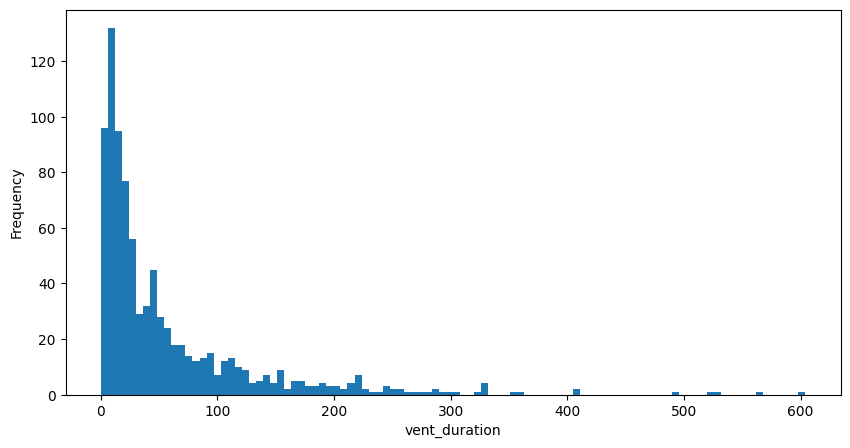

Proportion of patients with vent_duration less than 144 hours:  0.9464378575143005
Number of unique vent_duration values:  859


In [22]:
from matplotlib import pyplot as plt

# Get the unique vent_duration values
vent_duration = merged_data['vent_duration'].unique()

# Plot the distribution of unique vent_duration values
plt.figure(figsize=(10, 5))
plt.hist(vent_duration, bins=100)
plt.xlabel('vent_duration')
plt.ylabel('Frequency')
plt.show()

# Get the proportion of patients with vent_duration less than 144 hours (6 days)
print('Proportion of patients with vent_duration less than 144 hours: ', len(merged_data.loc[merged_data['vent_duration'] < 144]) / len(merged_data))

# Get the number of unique vent_duration values
print('Number of unique vent_duration values: ', len(vent_duration))

In [23]:
# To model this problem as a classification problem, we will create one bin for each hour up to the maximum vent_duration value.
# Iterate through the rows of the merged_data
for i in range(len(merged_data)):
    # Get the vent_duration value for this row
    vent_duration = merged_data.iloc[i]['vent_duration']
    # Get the number of hours in the vent_duration
    hours = vent_duration
    # If the number of hours is less than 1, set the vent_duration to 1
    if hours < 1:
        hours = 1
    # Set the vent_duration to the number of hours. Round up to the nearest integer
    merged_data.at[i, 'vent_duration'] = int(np.ceil(hours))

# Get the unique vent_duration bin values
vent_duration_bins = merged_data['vent_duration'].unique()
print('Number of unique vent_duration bins: ', len(vent_duration_bins))


Number of unique vent_duration bins:  216


In [24]:
# Get the number of unique stay_ids in merged_data
print('Number of unique stay_ids in merged_data: ', len(merged_data['stay_id'].unique()))


Number of unique stay_ids in merged_data:  1924


In [26]:
# Remove any empty rows
merged_data = merged_data.dropna()

# sort the merged_data by ascending stay_id and ascending charttime
merged_data = merged_data.sort_values(by=['stay_id', 'charttime'], ascending=[True, True])

# save the merged data as a csv file
merged_data.to_csv('data/merged_data.csv', index=False)

### Design a time-series classification model using LSTM RNN + Multi Layer Perceptron (MLP) classifier

In [28]:
# Do a train-test split using merged_data
from sklearn.model_selection import train_test_split

# Get the features and labels
X = merged_data.drop(['stay_id', 'charttime', 'liver_function_test','vent_duration'], axis=1)
y = merged_data['vent_duration']

# Iterate through the rows of X
# Convert every 4 rows into a numpy array
X = np.array([X.iloc[i:i+n].values for i in range(0, len(X), n)])
print(X.shape)

# only one label per patient
y = np.array([y.iloc[i] for i in range(0, len(y), n)])
print(y.shape)

# Ensure that X has the shape (1923, 4, 13)
assert X.shape == (1923, n, 12)

# Ensure that y has the shape (1923,)
assert y.shape == (1923,)

# Keep 80% of the data in X and y for training and 20% for testing
# X_train = 80% of 1923 rows = 1538 rows
# X_test = 20% of 1923 rows = 385 rows
# y_train = 80% of 1923 rows = 1538 rows
# y_test = 20% of 1923 rows = 385 rows

# Get the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

# Print the shape of X_train, X_test, y_train, y_test
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)


(1923, 4, 12)
(1923,)
X_train shape:  (1730, 4, 12)
X_test shape:  (193, 4, 12)
y_train shape:  (1730,)
y_test shape:  (193,)


In [29]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Get the mean difference between the predicted and actual vent_duration_bin values
def MTD(y_true, y_pred):
    """
    :param y_true: A tensor of the true class labels
    :param y_pred: A tensor of the predicted class labels
    """
    
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def acc24(y_true, y_pred):
    """
    :param y_true: A tensor of the true class labels
    :param y_pred: A tensor of the predicted class labels
    """
    
    # Get the absolute difference between the true and predicted values
    diff = tf.abs(y_true - y_pred)
    # Return the proportion of values where the difference is less than 24 hours
    return tf.reduce_mean(tf.cast(diff < 24, dtype=tf.float32))

def acc12(y_true, y_pred):
    """
    :param y_true: A tensor of the true class labels
    :param y_pred: A tensor of the predicted class labels
    """
    
    # Get the absolute difference between the true and predicted values
    diff = tf.abs(y_true - y_pred)
    # Return the proportion of values where the difference is less than 12 hours
    return tf.reduce_mean(tf.cast(diff < 12, dtype=tf.float32))

def acc6(y_true, y_pred):
    """
    :param y_true: A tensor of the true class labels
    :param y_pred: A tensor of the predicted class labels
    """
    
    # Get the absolute difference between the true and predicted values
    diff = tf.abs(y_true - y_pred)
    # Return the proportion of values where the difference is less than 6 hours
    return tf.reduce_mean(tf.cast(diff < 6, dtype=tf.float32))

def f1_score(y_true, y_pred):
    """
    :param y_true: A tensor of the true class labels
    :param y_pred: A tensor of the predicted class labels
    """
    
    # Get the true and predicted class labels
    y_true = tf.cast(y_true, dtype=tf.int32)
    y_pred = tf.cast(y_pred, dtype=tf.int32)
    
    # Get the confusion matrix using tensorflow
    cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)
    
    # Get the true positives, false positives, and false negatives
    tp = tf.cast(cm[1, 1], dtype=tf.float32)
    fp = tf.cast(cm[0, 1], dtype=tf.float32)
    fn = tf.cast(cm[1, 0], dtype=tf.float32)
    
    # Calculate the precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    # Calculate the F1 score
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1

2023-04-13 20:37:53.734865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 20:37:53.767845: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 20:37:53.768765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 20:37:54.454677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [30]:
# Import keras and tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input, Concatenate
from tensorflow.keras.models import Model

# Define timesteps and the number of features. After data preprocessing, there are 13 dynamic features and no static features
n_timesteps = 4
n_features = 12

# Number of output classes
n_outputs = 216

# RNN + MLP Model

# Define input layer
recurrent_input = Input(shape=(n_timesteps,n_features),name="TIMESERIES_INPUT")

# RNN Layers
# layer - 1
rec_layer_one = Bidirectional(LSTM(64,
                              activation='sigmoid',
                              kernel_regularizer=regularizers.L2(0.001),
                              recurrent_regularizer=regularizers.L2(0.001),
                              return_sequences=True),
                              name="BIDIRECTIONAL_LAYER_1")(recurrent_input)
rec_layer_one = Dropout(0.2,name="DROPOUT_LAYER_1")(rec_layer_one)

# layer - 2
rec_layer_two = Bidirectional(LSTM(32,
                              activation='sigmoid',
                              kernel_regularizer=regularizers.L2(0.001),
                              recurrent_regularizer=regularizers.L2(0.001)),
                              name ="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
rec_layer_two = Dropout(0.2,name="DROPOUT_LAYER_2")(rec_layer_two)

# MLP Layers
static_layer_one = Dense(32, kernel_regularizer=regularizers.L2(0.01), activation='sigmoid',name="DENSE_LAYER_1")(rec_layer_two)
# static_layer_one = Dropout(0.1,name="DROPOUT_LAYER_3")(static_layer_one)
# static_layer_two = Dense(32, kernel_regularizer=regularizers.L2(0.01), activation='relu',name="DENSE_LAYER_2")(static_layer_one)
output = Dense(n_outputs, kernel_regularizer=regularizers.L2(0.01), activation='softmax',name="DENSE_LAYER_3")(static_layer_one)

# Compile Model
model = Model(inputs=[recurrent_input],outputs=[output])

def categorical_focal_loss(alpha, gamma):
    def focal_loss(y_true, y_pred):
        """
        :param y_true: A tensor of the true class labels
        :param y_pred: A tensor of the predicted class probabilities
        """

        # Convert the true class labels to one-hot encoding
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

        # Calculate the cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)

        # Calculate the weight for each example
        alpha_factor = tf.reduce_sum(alpha * y_true, axis=-1)

        # Calculate the modulating factor for each example
        gamma_factor = tf.pow(1 - y_pred, gamma)

        # Scale the focal weight by the modulating factor
        focal_weight = alpha_factor * gamma_factor

        # Calculate the final loss
        loss = focal_weight * ce_loss
        return tf.reduce_mean(loss, axis=0)
    return focal_loss


# SGD optimizer
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, weight_decay=0.01)
# Use focal loss as the loss function
model.compile(loss=categorical_focal_loss(alpha=0.2, gamma=2.0), optimizer=opt, metrics=[MTD, acc6, acc12, acc24])

# Use categorical cross entropy as the loss function
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
model.summary()


2023-04-13 20:37:55.169126: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TIMESERIES_INPUT (InputLaye  [(None, 4, 12)]          0         
 r)                                                              
                                                                 
 BIDIRECTIONAL_LAYER_1 (Bidi  (None, 4, 128)           39424     
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_1 (Dropout)   (None, 4, 128)            0         
                                                                 
 BIDIRECTIONAL_LAYER_2 (Bidi  (None, 64)               41216     
 rectional)                                                      
                                                                 
 DROPOUT_LAYER_2 (Dropout)   (None, 64)                0         
                                                             

In [31]:
# Train the network
history = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2, validation_data=(X_test, y_test))

Epoch 1/10
1730/1730 - 15s - loss: 0.4499 - MTD: 42.3931 - acc6: 0.1382 - acc12: 0.3202 - acc24: 0.5688 - val_loss: 0.1811 - val_MTD: 39.1250 - val_acc6: 0.1347 - val_acc12: 0.3212 - val_acc24: 0.6477 - 15s/epoch - 8ms/step
Epoch 2/10
1730/1730 - 12s - loss: 0.1142 - MTD: 42.3931 - acc6: 0.1382 - acc12: 0.3202 - acc24: 0.5688 - val_loss: 0.0668 - val_MTD: 39.1250 - val_acc6: 0.1347 - val_acc12: 0.3212 - val_acc24: 0.6477 - 12s/epoch - 7ms/step
Epoch 3/10
1730/1730 - 12s - loss: 0.0434 - MTD: 42.3933 - acc6: 0.1382 - acc12: 0.3202 - acc24: 0.5688 - val_loss: 0.0266 - val_MTD: 39.1250 - val_acc6: 0.1347 - val_acc12: 0.3212 - val_acc24: 0.6477 - 12s/epoch - 7ms/step
Epoch 4/10
1730/1730 - 12s - loss: 0.0184 - MTD: 42.3931 - acc6: 0.1382 - acc12: 0.3202 - acc24: 0.5688 - val_loss: 0.0125 - val_MTD: 39.1250 - val_acc6: 0.1347 - val_acc12: 0.3212 - val_acc24: 0.6477 - 12s/epoch - 7ms/step
Epoch 5/10
1730/1730 - 12s - loss: 0.0096 - MTD: 42.3932 - acc6: 0.1382 - acc12: 0.3202 - acc24: 0.5688 